<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Focal_Loss_ResNet50_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [1]:
!nvidia-smi

Tue May 19 09:08:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# **Clone Data**

In [4]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 52.14 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [7]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_train

In [0]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [14]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# **Build Model**

### **Use ResNet50 + fine tuning**

In [0]:
def build_model():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])
  return model

In [0]:
model = build_model()

### **Architecture**

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### **Callbacks**

In [0]:
model_path = '/content/Focal-Loss_ResNet50_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [37]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=EPOCHS,
                            callbacks=cb_list)

Epoch 1/100
 84/197 [===========>..................] - ETA: 34s - loss: 0.4502 - acc: 0.1083
Epoch 00001: val_loss improved from -inf to 0.45023, saving model to /content/Focal-Loss_ResNet50_model.h5
197/197 [==============================] - 201s 1s/step - loss: 0.1123 - acc: 0.2047 - val_loss: 0.4502 - val_acc: 0.1083
Epoch 2/100
 84/197 [===========>..................] - ETA: 34s - loss: 0.7504 - acc: 0.1083
Epoch 00002: val_loss improved from 0.45023 to 0.75044, saving model to /content/Focal-Loss_ResNet50_model.h5
197/197 [==============================] - 146s 743ms/step - loss: 0.0882 - acc: 0.2946 - val_loss: 0.7504 - val_acc: 0.1083
Epoch 3/100
 84/197 [===========>..................] - ETA: 34s - loss: 0.6940 - acc: 0.1094
Epoch 00003: val_loss did not improve from 0.75044
197/197 [==============================] - 146s 741ms/step - loss: 0.0790 - acc: 0.3631 - val_loss: 0.6940 - val_acc: 0.1094
Epoch 4/100
 84/197 [===========>..................] - ETA: 34s - loss: 0.2328 - 

In [0]:
model.save_weights('/content/Focal-Loss_ResNet50_weights.h5')

# **Accuracy and Loss Graph**

### **Accuracy**

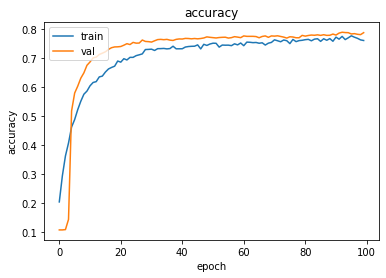

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

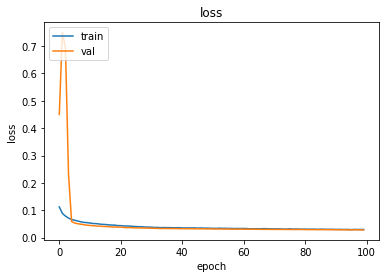

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [40]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 16s 16ms/step


### **Classification Report**

In [41]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[  7   2  14   0   9   9   0]
 [  3  21   9   1   4   9   0]
 [  2   4  77   0  15  27   0]
 [  0   1   2   3   0   9   0]
 [  0   1  18   1  43  46   1]
 [  1   2  17   0  14 614   1]
 [  0   2   3   1   0   4   5]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.54      0.17      0.26        41
         bcc       0.64      0.45      0.52        47
         bkl       0.55      0.62      0.58       125
          df       0.50      0.20      0.29        15
         mel       0.51      0.39      0.44       110
          nv       0.86      0.95      0.90       649
        vasc       0.71      0.33      0.45        15

    accuracy                           0.77      1002
   macro avg       0.61      0.44      0.49      1002
weighted avg       0.75      0.77      0.75      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[  7   2  14   0   9   9   0]
 [  3  21   9   1   4   9   0]
 [  2   4  77   0  15  27   0]
 [  0   1   2   3   0   9   0]
 [  0   1  18   1  43  46   1]
 [  1   2  17   0  14 614   1]
 [  0   2   3   1   0   4   5]]


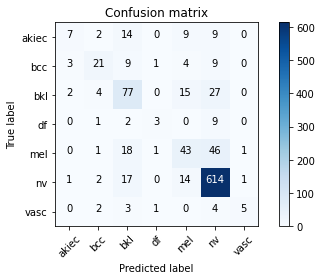

In [42]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [44]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.7778
specificity: 0.8750


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block3_3_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.857
	bkl            	(2)	with probability 0.086
	nv             	(5)	with probability 0.019
	akiec          	(0)	with probability 0.017
	bcc            	(1)	with probability 0.014
Explanation for 'mel'


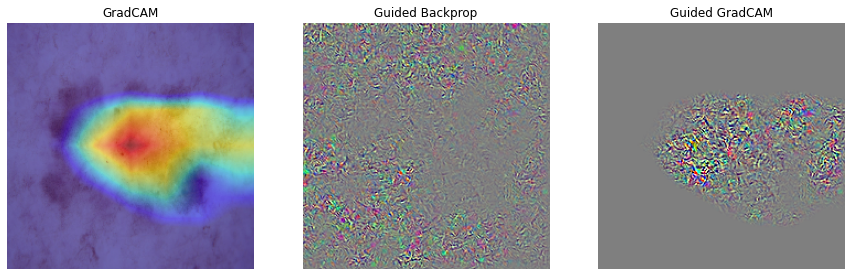

In [50]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.595
	bkl            	(2)	with probability 0.189
	nv             	(5)	with probability 0.165
	akiec          	(0)	with probability 0.017
	bcc            	(1)	with probability 0.013
Explanation for 'mel'


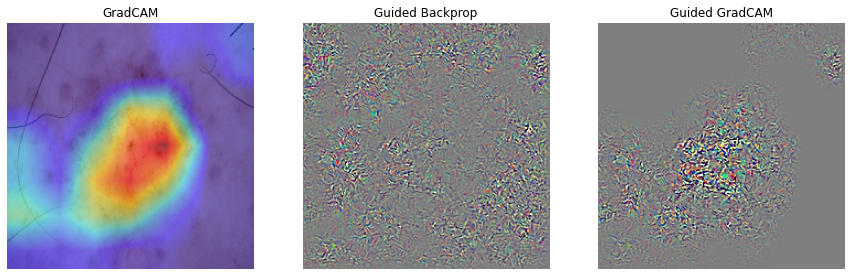

In [52]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.543
	bkl            	(2)	with probability 0.216
	nv             	(5)	with probability 0.128
	vasc           	(6)	with probability 0.043
	bcc            	(1)	with probability 0.034
Explanation for 'mel'


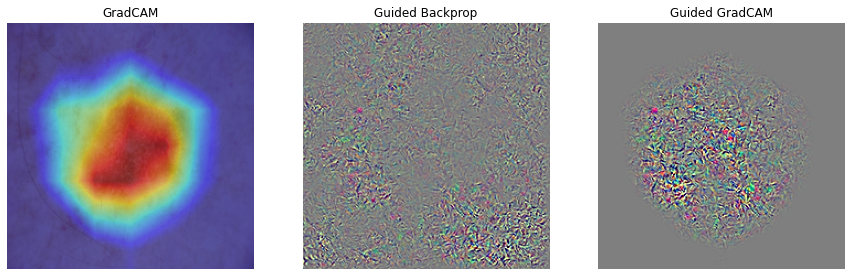

In [54]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	nv             	(5)	with probability 0.434
	mel            	(4)	with probability 0.396
	bkl            	(2)	with probability 0.111
	df             	(3)	with probability 0.022
	akiec          	(0)	with probability 0.014
Explanation for 'nv'


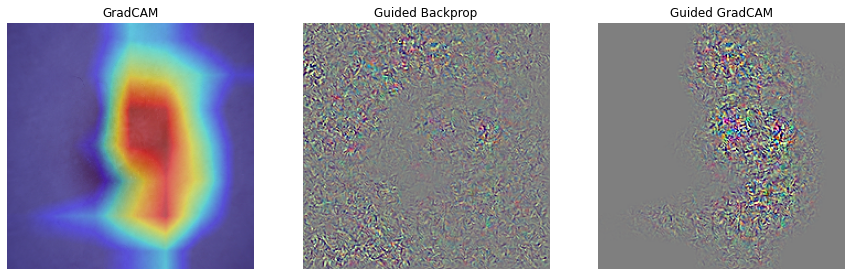

In [56]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.472
	nv             	(5)	with probability 0.279
	bkl            	(2)	with probability 0.098
	df             	(3)	with probability 0.081
	vasc           	(6)	with probability 0.029
Explanation for 'mel'


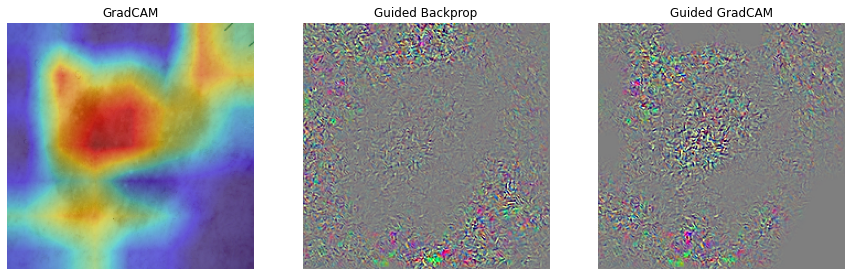

In [58]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	df             	(3)	with probability 0.715
	vasc           	(6)	with probability 0.100
	bkl            	(2)	with probability 0.099
	mel            	(4)	with probability 0.042
	nv             	(5)	with probability 0.034
Explanation for 'df'


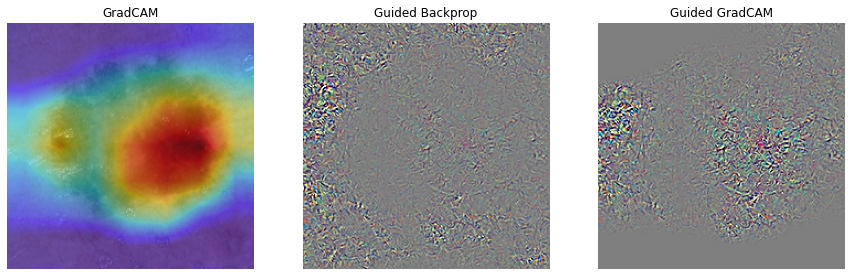

In [60]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	nv             	(5)	with probability 0.584
	vasc           	(6)	with probability 0.232
	bkl            	(2)	with probability 0.074
	mel            	(4)	with probability 0.039
	bcc            	(1)	with probability 0.034
Explanation for 'nv'


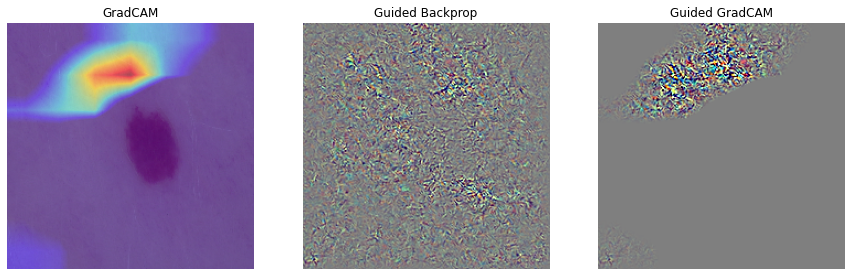

In [62]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [0]:
files.download('/content/Focal-Loss_ResNet50_model.h5')
files.download('/content/Focal-Loss_ResNet50_weights.h5')